In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
N = 100 # total ids 
pi = 3.14

LRU

In [4]:
def LRU(y, x, request_time,con,C):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    x_t_j = np.zeros((N),int)
    file_req_time = np.zeros((N),int)

    # to find which users are connected to this cache 
    connected_users = np.where(con[:,j]==1)[0]
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    # file which is not requested but still in the cache
    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))
    a = np.where(a1 == 1)[0]
    # file requested but not in the cache.
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) 
    b = np.where(b1 == 1)[0]

    if len(a)>0 and len(b)>0:
      if len(a)>len(b):
        t = np.zeros(len(a))
        for k in range(len(a)):
          t[k] = file_req_time[a[k]]
        replace = (t).argsort()[:len(b)]
        for k in range(len(b)):
          y[j,a[int(replace[k])]] = 0
        for k in range(len(b)):
            y[j,b[k]] = 1
      
      else:
        t = np.zeros(len(b))
        for k in range(len(b)):
          t[k] = file_req_time[b[k]]
        replace = (t).argsort()[:len(a)]
        for k in range(len(a)):
          y[j,b[int(replace[k])]] = 1
        for k in range(len(a)):
          y[j,a[k]] = 0
  new = y.reshape(J*N)
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

LFU

In [5]:
def LFU(y,x,freq,con,C):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    file_freq = np.zeros((N),int)
    x_t_j = np.zeros((N),int)

    # to find which users are connected to this cache 
    connected_users = np.where(con[:,j]==1)[0]
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    # file which is not requested but still in the cache
    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))
    a = np.where(a1 == 1)[0]
    # file requested but not in the cache.
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) 
    b = np.where(b1 == 1)[0]

    if len(a)>0 and len(b)>0:
      if len(a)>len(b):
        t = np.zeros(len(a))
        for k in range(len(a)):
          t[k] = file_freq[a[k]]
        replace = (t).argsort()[:len(b)]
        for k in range(len(b)):
          y[j,a[int(replace[k])]] = 0
        for k in range(len(b)):
            y[j,b[k]] = 1
      
      else:
        t = np.zeros(len(b))
        for k in range(len(b)):
          t[k] = file_freq[b[k]]
        replace = (t).argsort()[:len(a)]
        for k in range(len(a)):
          y[j,b[int(replace[k])]] = 1
        for k in range(len(a)):
          y[j,a[k]] = 0
  new = y.reshape(J*N)
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

perturbed count

In [6]:
def per_count(eta,count,normal_dist):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = 'f4')
  for i in range(I):
    p_count[:,i] = count[:,i] + np.round(np.multiply(eta, normal_dist[:,i]).reshape(N),4)
  return p_count

GREEDY

In [7]:
def Greedy(con,count,C):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = int)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = int)
  z = np.zeros((I,N),dtype = 'f4')
  mark = np.zeros((I,N),dtype = int)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_file] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

MARKER

In [8]:
def Marker(y,x,bit,con,phase,C):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  
  for j in range(J):
    x_t_j = np.zeros((N),int)
    connected_users = np.where(con[:,j]==1)[0]
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
    x_t_j = np.minimum(np.ones((N),int),x_t_j)

    phase[j,:] += x_t_j  
    phase[j] = np.minimum(np.ones((N),int),phase[j]) 
    # new phase
    if np.sum(phase[j]) >= C:
      bit[j,:] = np.zeros((1,N),int) #start new phase
      phase[j,:] = np.zeros((1,N),int)
      
    # file which is not requested but still in the cache
    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))
    a = np.where(a1 == 1)[0]
    # file requested but not in the cache.
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) 
    b = np.where(b1 == 1)[0]
    # file requested available in cache
    c1 = np.logical_and(y[j],x_t_j.reshape(1,N)).reshape(N)
    c = np.where(c1 == 1)[0]
    
    # if requested file is available then bit is set for that file
    for i in range(len(c)):
      bit[j,c[i]] = 1 
    
    # now replace add all b1 files in cache and evict randomly untill end of the face.
    for i in range(len(b)):
      for n in range(N):
        if np.logical_and(y[j,n],np.logical_not(bit[j,n])) == 1:
          y[j,n] = 0
          bit[j,n] = 1
          break
    for i in range(len(b)):
      y[j,b[i]] = 1
              
  new = y.reshape(J*N).copy()
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,bit,download,phase

SINGLE CACHE

In [9]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [10]:
I = 1 #users
T = 50000
l = 1000000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [11]:
req1.shape

(2001000,)

In [12]:
req = req1[l:l+I*T].reshape(I,T)
req

array([[98., 50., 48., ..., 60., 41., 92.]])

In [16]:
gen_req = gen_req1[l:l+I*T].reshape(I,T)
gen_req

array([[ 3., 29., 77., ..., 77., 95., 27.]])

In [17]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_mrk = np.zeros((J,N),dtype = int)
y_mrk[:,:C] = np.ones((J,C),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
reward_mrk =  np.zeros((T),int)
hits_mrk =  []
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
download_mrk = []
mrk_downloads_slotwise = np.zeros((T),int)
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 
bit = np.zeros((J,N),int)
phase = np.zeros((J,N),int)
normal = random.normal(0,1,[N,I])

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[int(req[i,t]),i] += 1
    x_t1[int(gen_req[i,t]),i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  ireward_mrk =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    temp5 = np.zeros((N),int)

    connected_cache = np.where(connection[i] == 1)[0]
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
      temp5 += y_mrk[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])
    ireward_mrk[i] += np.dot(np.minimum(np.ones(N),temp5),x_t[:,i])


  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_mrk[t] =  np.sum(ireward_mrk)
  reward_mrkc = np.sum(reward_mrk)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  y_LFU, LFU_downloads_slotwise[t] = LFU(y_LFU,x_t,count,connection,C)
  y_LRU, LRU_downloads_slotwise[t] = LRU(y_LRU,x_t,req_time,connection,C)
  y_LSTM, LSTM_downloads_slotwise[t] = LRU(y_LSTM,x_t1,req_time1,connection,C)
  y_mrk, bit, mrk_downloads_slotwise[t], phase = Marker(y_mrk,x_t,bit,connection,phase,C)
   
  eta = round(pow(I,0.75)*pow(2*(np.log(N/C)+1),0.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count,normal)
  old_FTPL = y_FTPL.reshape(J*N)
  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = int)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
  new_FTPL = y_FTPL.reshape(J*N)
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_mrk.append(np.sum(mrk_downloads_slotwise)/(t+1))
  download_FTPL.append(np.sum(FTPL_downloads_slotwise)/(t+1))
  download_LFU.append(np.sum(LFU_downloads_slotwise)/(t+1))
  download_LRU.append(np.sum(LRU_downloads_slotwise)/(t+1))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise)/(t+1))
  hits_mrk.append(reward_mrkc/(t+1))
  hits_LRU.append(reward_LRUc/(t+1))
  hits_LFU.append(reward_LFUc/(t+1))
  hits_FTPL.append(reward_FTPLc/(t+1))
  hits_LSTM.append(reward_LSTMc/(t+1))
  if t %10000 == 0:
    print(t,download_mrk[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_mrk[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 1.0 5.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0
10000 0.9501049895010499 0.006199380061993801 0.944005599440056 0.9494050594940506 0.8560143985601439 0.04989501049895011 0.060193980601939805 0.05599440055994401 0.050594940505949405 0.143985601439856
20000 0.9496525173741313 0.005249737513124344 0.9412029398530074 0.9495525223738813 0.8574071296435178 0.05034748262586871 0.05849707514624269 0.05879706014699265 0.050447477626118696 0.1425928703564822
30000 0.9488683710542982 0.0034998833372220928 0.9384020532648911 0.9497016766107796 0.8587380420652645 0.05113162894570181 0.05989800339988667 0.06159794673510883 0.050298323389220356 0.1412619579347355
40000 0.9485012874678133 0.003074923126921827 0.936801579960501 0.9498012549686258 0.8579785505362366 0.05149871253218669 0.06192345191370216 0.063198420039499 0.05019874503137422 0.1420214494637634


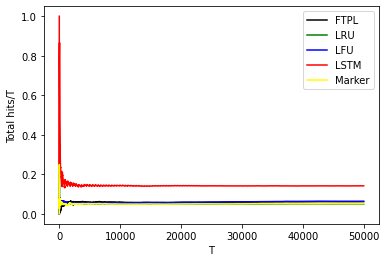

In [27]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.plot(hits_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('Total hits/T')
plt.legend()
plt.savefig('hit-rate(I=J=1).png')

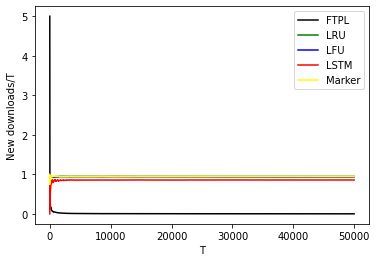

In [28]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.plot(download_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('New downloads/T')
plt.legend()
plt.savefig('download-rate(I=J=1).png')

I = 5 J = 3 d = 3

In [29]:
T = 50000
C = 5
I = 5
J = 3
degree = 3

In [30]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 1, 0]])

In [31]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [32]:
req = req1[l:].reshape(I,-1)
req.shape

(5, 200200)

In [33]:
gen_req = gen_req1[l:].reshape(I,-1)
gen_req.shape

(5, 251000)

In [34]:
req

array([[98., 50., 48., ..., 39., 25., 47.],
       [44., 72., 44., ..., 51., 16., 38.],
       [96., 55., 75., ..., 42., 52., 30.],
       [95., 73., 93., ..., 69., 43., 31.],
       [71., 24., 69., ..., 41., 75.,  6.]])

In [35]:
gen_req

array([[ 3., 29., 77., ..., 29., 31., 77.],
       [28.,  3., 29., ..., 29., 31.,  3.],
       [28., 77., 29., ..., 77., 29., 31.],
       [28.,  3., 57., ..., 57.,  3., 29.],
       [31., 28., 57., ..., 28., 57., 37.]])

In [36]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_mrk = np.zeros((J,N),dtype = int)
y_mrk[:,:C] = np.ones((J,C),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
reward_mrk =  np.zeros((T),int)
hits_mrk =  []
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
download_mrk = []
mrk_downloads_slotwise = np.zeros((T),int)
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 
bit = np.zeros((J,N),int)
phase = np.zeros((J,N),int)
normal = random.normal(0,1,[N,I])

for t in range(T):
  x_t = np.zeros((N,I),dtype = int)
  x_t1 = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[int(req[i,t]),i] += 1
    x_t1[int(gen_req[i,t]),i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  ireward_mrk =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    temp5 = np.zeros((N),int)

    connected_cache = np.where(connection[i] == 1)[0]
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
      temp5 += y_mrk[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])
    ireward_mrk[i] += np.dot(np.minimum(np.ones(N),temp5),x_t[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_mrk[t] =  np.sum(ireward_mrk)
  reward_mrkc = np.sum(reward_mrk)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection,C)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection,C)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection,C)
  [y_mrk,bit,mrk_downloads_slotwise[t],phase] = Marker(y_mrk,x_t,bit,connection,phase,C) 

  eta = round(pow(I,0.75)*pow(2*(np.log(N/C)+1),0.25)*pow((t+1)/(J*degree*C),0.5),4)
  perturbed_count=per_count(eta,count,normal)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,Z] = Greedy(connection,perturbed_count,C) 
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL)))

  download_mrk.append(np.sum(mrk_downloads_slotwise)/(t+1))
  download_FTPL.append(np.sum(FTPL_downloads_slotwise)/(t+1))
  download_LFU.append(np.sum(LFU_downloads_slotwise)/(t+1))
  download_LRU.append(np.sum(LRU_downloads_slotwise)/(t+1))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise)/(t+1))
  hits_mrk.append(reward_mrkc/(t+1))
  hits_LRU.append(reward_LRUc/(t+1))
  hits_LFU.append(reward_LFUc/(t+1))
  hits_FTPL.append(reward_FTPLc/(t+1))
  hits_LSTM.append(reward_LSTMc/(t+1))

  if t %10000 == 0:
    print(t,download_mrk[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_mrk[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 9.0 15.0 9.0 9.0 4.0 0.0 0.0 0.0 0.0 1.0
10000 8.463953604639537 0.0164983501649835 8.385761423857614 8.452654734526547 7.979302069793021 0.33296670332966705 0.44625537446255376 0.40275972402759724 0.35776422357764226 0.6412358764123588
20000 8.461726913654317 0.00974951252437378 8.393030348482576 8.458877056147193 7.980350982450878 0.33783310834458274 0.45557722113894306 0.3807809609519524 0.35553222338883056 0.6413679316034199
30000 8.46181793940202 0.007166427785740476 8.390953634878837 8.46178460717976 7.978300723309223 0.3382220592646912 0.45668477717409417 0.3793540215326156 0.3545881803939869 0.6413119562681244
40000 8.460388490287743 0.006374840628984276 8.388990275243119 8.457913552161196 7.978950526236844 0.33966650833729156 0.4647133821654459 0.377265568360791 0.35689107772305695 0.6421839454013649


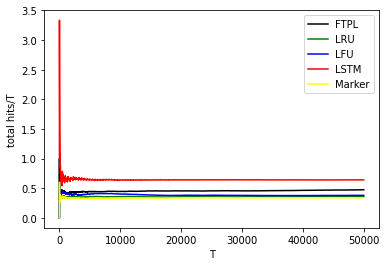

In [37]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.plot(hits_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('total hits/T')
plt.legend()
plt.savefig('hit-rate(I=5 J=3 d=3).png')

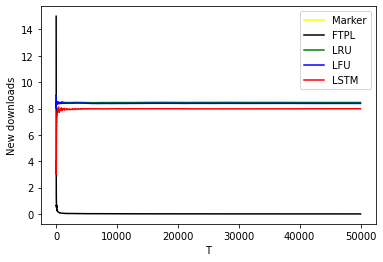

In [38]:
plt.plot(download_mrk,'yellow',label='Marker')
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('download-rate(I=5 J=3 d=3).png')

I = 15 J = 10 d = 7

In [61]:
I = 10
J = 4
C = 10
degree = 3
normal = random.normal(0,1,[N,I])
T = 50000

In [62]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [63]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [64]:
req = req1[l:].reshape(I,-1)
req.shape

(10, 100100)

In [65]:
gen_req = gen_req1[l:].reshape(I,-1)
gen_req.shape

(10, 125500)

In [66]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_mrk = np.zeros((J,N),dtype = int)
y_mrk[:,:C] = np.ones((J,C),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
reward_mrk =  np.zeros((T),int)
hits_mrk =  []
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
download_mrk = []
mrk_downloads_slotwise = np.zeros((T),int)
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 
bit = np.zeros((J,N),int)
phase = np.zeros((J,N),int)
for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[int(req[i,t]),i] += 1
    x_t1[int(gen_req[i,t]),i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  ireward_mrk =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    temp5 = np.zeros((N),int)

    connected_cache = np.where(connection[i] == 1)[0]
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
      temp5 += y_mrk[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])
    ireward_mrk[i] += np.dot(np.minimum(np.ones(N),temp5),x_t[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_mrk[t] =  np.sum(ireward_mrk)
  reward_mrkc = np.sum(reward_mrk)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection,C)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection,C)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection,C)
  [y_mrk,bit,mrk_downloads_slotwise[t],phase] = Marker(y_mrk,x_t,bit,connection,phase,C) 

  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count,normal)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,Z] = Greedy(connection,perturbed_count,C) 
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))

  download_mrk.append(np.sum(mrk_downloads_slotwise)/(t+1))
  download_FTPL.append(np.sum(FTPL_downloads_slotwise)/(t+1))
  download_LFU.append(np.sum(LFU_downloads_slotwise)/(t+1))
  download_LRU.append(np.sum(LRU_downloads_slotwise)/(t+1))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise)/(t+1))
  hits_mrk.append(reward_mrkc/(t+1))
  hits_LRU.append(reward_LRUc/(t+1))
  hits_LFU.append(reward_LFUc/(t+1))
  hits_FTPL.append(reward_FTPLc/(t+1))
  hits_LSTM.append(reward_LSTMc/(t+1))

  if t %1000 == 0:
    print(t,download_mrk[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_mrk[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 12.0 38.0 12.0 12.0 10.0 0.0 0.0 0.0 0.0 1.0
1000 10.683316683316683 0.2987012987012987 10.521478521478521 10.666333666333667 10.094905094905094 1.056943056943057 1.3086913086913088 1.2297702297702298 1.0709290709290709 1.6533466533466534
2000 10.683658170914542 0.19890054972513743 10.498250874562718 10.652673663168416 10.147426286856572 1.0579710144927537 1.3243378310844578 1.2663668165917041 1.0974512743628186 1.6111944027986007
3000 10.695768077307564 0.1526157947350883 10.49516827724092 10.651116294568476 10.147284238587138 1.040986337887371 1.3385538153948684 1.2602465844718427 1.096634455181606 1.607130956347884
4000 10.69832541864534 0.13046738315421144 10.499625093726568 10.663834041489627 10.176455886028492 1.036990752311922 1.3524118970257435 1.2461884528867784 1.0862284428892777 1.578105473631592
5000 10.697860427914417 0.10937812437512498 10.485902819436113 10.651869626074784 10.12997400519896 1.0357928414317137 1.3615276944611079 1.255748850229954 1.0989802039592083 1.61

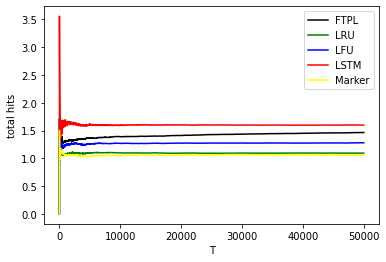

In [67]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.plot(hits_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('hit-rate(I=10 J=4 d=3).png')

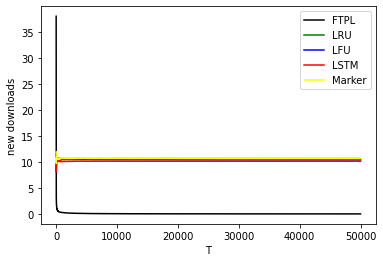

In [68]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.plot(download_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('download-rate(I=10 J=4 d=3).png')